In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchaudio.transforms as T
from torchvision.models import resnet50
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 23
train_size = 0.8

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

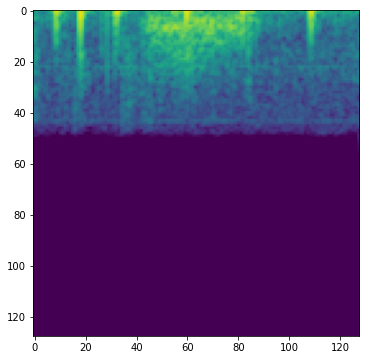

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 12):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 12):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(12)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 12)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [18]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [19]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet50

### No Augmentation

In [20]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = False, aug_type = 'No', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
Train
0.7977638537207703
TEST
loss: 20.850776278783403
accuracy: 0.2984126984126984
******************
epoch: 1
Train
0.8985318261730567
TEST
loss: 0.8735804359118143
accuracy: 0.6317460317460317
******************
epoch: 2
Train
0.6669242098465905
TEST
loss: 4.819603636908153
accuracy: 0.3682539682539683
******************
epoch: 3
Train
0.6346890119165537
TEST
loss: 0.6546787496597047
accuracy: 0.7873015873015873
******************
epoch: 4
Train
0.5662187895100679
TEST
loss: 0.6460374555890522
accuracy: 0.7555555555555555
******************
epoch: 5
Train
0.51331231509342
TEST
loss: 0.7359726852840848
accuracy: 0.6888888888888889
******************
epoch: 6
Train
0.5550895370454235
TEST
loss: 0.6881554586546762
accuracy: 0.746031746031746
******************
epoch: 7
Train
0.44109815600564123
TEST
loss: 0.7662831873174698
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.40636311356655846
TEST
loss: 0.7744902417773292
accuracy: 0.780952380952381
**************

In [21]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8045685279187818


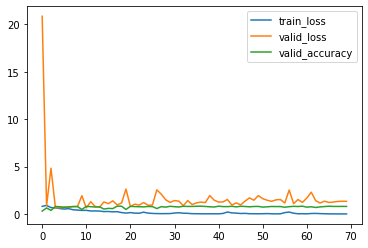

In [22]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [23]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8315401170535917
TEST
loss: 2.7551954099110194
accuracy: 0.5365079365079365
******************
epoch: 1
Train
0.6400791004217268
TEST
loss: 0.6449206753382607
accuracy: 0.8063492063492064
******************
epoch: 2
Train
0.5845654404191767
TEST
loss: 0.5543414336348337
accuracy: 0.7746031746031746
******************
epoch: 3
Train
0.5102888148772139
TEST
loss: 1.2944964306695121
accuracy: 0.7111111111111111
******************
epoch: 4
Train
0.492763019867413
TEST
loss: 0.4978874847056374
accuracy: 0.8
******************
epoch: 5
Train
0.5265590119352409
TEST
loss: 0.5593205310995617
accuracy: 0.8095238095238095
******************
epoch: 6
Train
0.45166714985376316
TEST
loss: 0.6504580064425393
accuracy: 0.8095238095238095
******************
epoch: 7
Train
0.4228025476453416
TEST
loss: 0.5555683370620486
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.35429487794614006
TEST
loss: 1.1491067901490226
accuracy: 0.406349206349

In [24]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8401015228426396


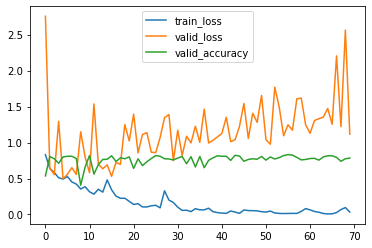

In [25]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [26]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.7881120397894983
TEST
loss: 0.9525415498112876
accuracy: 0.6666666666666666
******************
epoch: 1
Train
0.5778006671722964
TEST
loss: 0.6046991915929885
accuracy: 0.7682539682539683
******************
epoch: 2
Train
0.544393852601646
TEST
loss: 0.602404545886176
accuracy: 0.780952380952381
******************
epoch: 3
Train
0.5450268554914746
TEST
loss: 0.7365109509891934
accuracy: 0.7174603174603175
******************
epoch: 4
Train
0.5261130348569917
TEST
loss: 0.584169196987909
accuracy: 0.780952380952381
******************
epoch: 5
Train
0.49166132392534856
TEST
loss: 0.647503762207334
accuracy: 0.746031746031746
******************
epoch: 6
Train
0.4287277645918942
TEST
loss: 0.5367420868268089
accuracy: 0.7682539682539683
******************
epoch: 7
Train
0.3496807447920914
TEST
loss: 0.4742060919602712
accuracy: 0.8222222222222222
******************
epoch: 8
Train
0.33766773437771935
TEST
loss: 0.7648124740237281
accuracy: 0.733

In [27]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


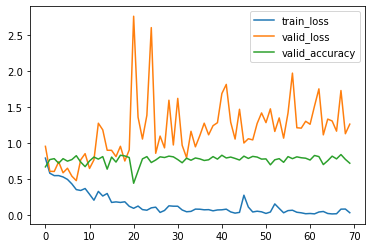

In [28]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [29]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8422770022020347
TEST
loss: 24.32085064479283
accuracy: 0.28253968253968254
******************
epoch: 1
Train
0.6025273927485214
TEST
loss: 0.6500162351699103
accuracy: 0.765079365079365
******************
epoch: 2
Train
0.5573256536312194
TEST
loss: 1.137677382287525
accuracy: 0.5650793650793651
******************
epoch: 3
Train
0.5194740484308117
TEST
loss: 0.6034645969905551
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.4256432753432072
TEST
loss: 0.4784810667946225
accuracy: 0.8253968253968254
******************
epoch: 5
Train
0.3950392060141605
TEST
loss: 0.5263586989470891
accuracy: 0.7841269841269841
******************
epoch: 6
Train
0.4207325278529106
TEST
loss: 2.323477926708403
accuracy: 0.28888888888888886
******************
epoch: 7
Train
0.4337678580434669
TEST
loss: 1.0863924904475137
accuracy: 0.4984126984126984
******************
epoch: 8
Train
0.3268496424456832
TEST
loss: 1.266223708977775
accuracy: 0.7

In [30]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8324873096446701


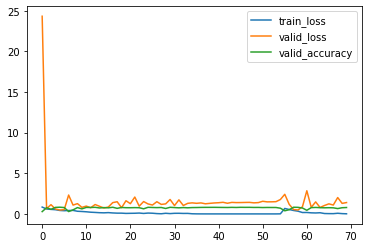

In [31]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [32]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8069862638606828
TEST
loss: 3.275779676437378
accuracy: 0.5206349206349207
******************
epoch: 1
Train
0.6640580839302163
TEST
loss: 0.7420653844636584
accuracy: 0.7333333333333333
******************
epoch: 2
Train
0.539293498581984
TEST
loss: 0.5936871697032262
accuracy: 0.7714285714285715
******************
epoch: 3
Train
0.5128642137416115
TEST
loss: 0.5835367286962176
accuracy: 0.8095238095238095
******************
epoch: 4
Train
0.4389375700090876
TEST
loss: 0.6727007432589456
accuracy: 0.7841269841269841
******************
epoch: 5
Train
0.42893766722478405
TEST
loss: 0.5636420609459044
accuracy: 0.8031746031746032
******************
epoch: 6
Train
0.431896880991029
TEST
loss: 1.1284275348224337
accuracy: 0.7206349206349206
******************
epoch: 7
Train
0.36102523845846074
TEST
loss: 0.48403027019803485
accuracy: 0.7873015873015873
******************
epoch: 8
Train
0.3187128503801711
TEST
loss: 0.6442852584142533
accuracy: 

In [33]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8020304568527918


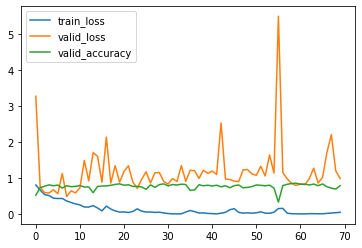

In [34]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [35]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8936652994705061
TEST
loss: 2.3264319472842745
accuracy: 0.39365079365079364
******************
epoch: 1
Train
0.6741382134538306
TEST
loss: 0.9037109539622352
accuracy: 0.5777777777777777
******************
epoch: 2
Train
0.6647289841775387
TEST
loss: 0.7685473061743237
accuracy: 0.7015873015873015
******************
epoch: 3
Train
0.6038029841054897
TEST
loss: 0.8213378548622131
accuracy: 0.7873015873015873
******************
epoch: 4
Train
0.545687906556512
TEST
loss: 0.8016767880273243
accuracy: 0.7714285714285715
******************
epoch: 5
Train
0.5275366957505796
TEST
loss: 1.1589874074572608
accuracy: 0.5111111111111111
******************
epoch: 6
Train
0.5607356005854982
TEST
loss: 1.6284384606376527
accuracy: 0.5619047619047619
******************
epoch: 7
Train
0.5451851041190108
TEST
loss: 1.1639460934533012
accuracy: 0.707936507936508
******************
epoch: 8
Train
0.5163956816893328
TEST
loss: 0.9087543924649556
accuracy: 0

In [36]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8730964467005076


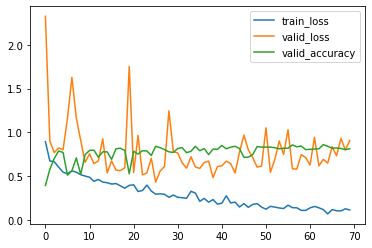

In [37]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [38]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9385912373863202
TEST
loss: 1.312639567965553
accuracy: 0.5968253968253968
******************
epoch: 1
Train
0.7516833964655378
TEST
loss: 0.7191793430419195
accuracy: 0.7238095238095238
******************
epoch: 2
Train
0.7151161988071263
TEST
loss: 0.6296776639090644
accuracy: 0.780952380952381
******************
epoch: 3
Train
0.6892094404286482
TEST
loss: 0.6727568598020645
accuracy: 0.8222222222222222
******************
epoch: 4
Train
0.6767081815255266
TEST
loss: 0.6160350621692718
accuracy: 0.7746031746031746
******************
epoch: 5
Train
0.6572742464525345
TEST
loss: 0.9091151307499598
accuracy: 0.5523809523809524
******************
epoch: 6
Train
0.706128622824659
TEST
loss: 0.6064352983520145
accuracy: 0.7873015873015873
******************
epoch: 7
Train
0.6628755903414453
TEST
loss: 0.6153695394122412
accuracy: 0.7492063492063492
******************
epoch: 8
Train
0.6540086101311554
TEST
loss: 0.6931019213464525
accuracy: 0.7

In [39]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8274111675126904


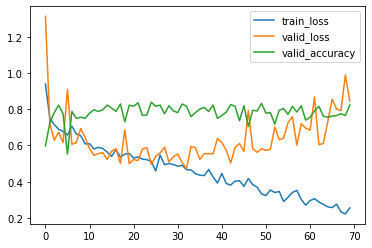

In [40]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [41]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.0091933264819473
TEST
loss: 37.94002640133812
accuracy: 0.2698412698412698
******************
epoch: 1
Train
0.771963018713914
TEST
loss: 1.16681089552622
accuracy: 0.6444444444444445
******************
epoch: 2
Train
0.757113093369721
TEST
loss: 1.0049109178876119
accuracy: 0.7142857142857143
******************
epoch: 3
Train
0.6874385018307032
TEST
loss: 0.697766449527135
accuracy: 0.7333333333333333
******************
epoch: 4
Train
0.6220350887587943
TEST
loss: 0.7107431396605477
accuracy: 0.707936507936508
******************
epoch: 5
Train
0.5895832448463955
TEST
loss: 1.0689332012146238
accuracy: 0.653968253968254
******************
epoch: 6
Train
0.631369501565353
TEST
loss: 0.9011783238441226
accuracy: 0.5936507936507937
******************
epoch: 7
Train
0.6055533148827678
TEST
loss: 0.7838807527981108
accuracy: 0.7238095238095238
******************
epoch: 8
Train
0.5737053674303226
TEST
loss: 0.7400405100413732
accuracy: 0.7428571

In [42]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.7868020304568528


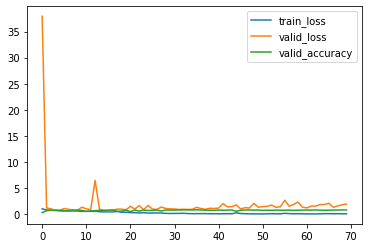

In [43]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [44]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8451409677932715
TEST
loss: 0.7019990989140101
accuracy: 0.7365079365079366
******************
epoch: 1
Train
0.613586141724166
TEST
loss: 0.7142415565157694
accuracy: 0.7238095238095238
******************
epoch: 2
Train
0.4871340850878557
TEST
loss: 1.754727450249687
accuracy: 0.4793650793650794
******************
epoch: 3
Train
0.4184991284388223
TEST
loss: 1.00724570372748
accuracy: 0.4253968253968254
******************
epoch: 4
Train
0.44648770586756886
TEST
loss: 0.5965875223515525
accuracy: 0.7619047619047619
******************
epoch: 5
Train
0.34817983831461696
TEST
loss: 0.781042546506912
accuracy: 0.7682539682539683
******************
epoch: 6
Train
0.35088373634245207
TEST
loss: 0.7786007548135424
accuracy: 0.6126984126984127
******************
epoch: 7
Train
0.2630677025549179
TEST
loss: 0.9327466368675232
accuracy: 0.7047619047619048
******************
epoch: 8
Train
0.29176918772878485
TEST
loss: 1.7253035375050136
accuracy: 0

In [45]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.7842639593908629


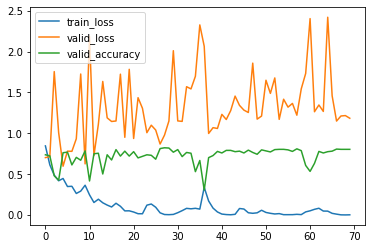

In [46]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [47]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8529354372698699
TEST
loss: 17.96640864780971
accuracy: 0.33015873015873015
******************
epoch: 1
Train
0.6507346020320562
TEST
loss: 1.5321407140247405
accuracy: 0.40634920634920635
******************
epoch: 2
Train
0.5559141244606143
TEST
loss: 0.5548008233781845
accuracy: 0.8095238095238095
******************
epoch: 3
Train
0.5007771724647146
TEST
loss: 0.7957503163625324
accuracy: 0.8095238095238095
******************
epoch: 4
Train
0.46540302051212035
TEST
loss: 0.8450533766595144
accuracy: 0.7555555555555555
******************
epoch: 5
Train
0.3936552328661948
TEST
loss: 0.6876284037317548
accuracy: 0.8
******************
epoch: 6
Train
0.4207332774440479
TEST
loss: 1.0415558788511488
accuracy: 0.6031746031746031
******************
epoch: 7
Train
0.3556067094242317
TEST
loss: 0.7546314658626677
accuracy: 0.746031746031746
******************
epoch: 8
Train
0.3893456439161414
TEST
loss: 0.8734239714486258
accuracy: 0.771428571428

In [48]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


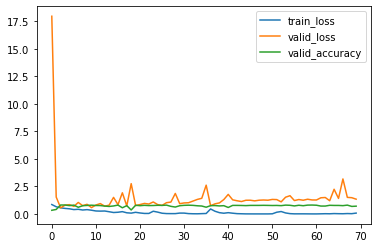

In [49]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [50]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8289057630882839
TEST
loss: 0.5901976787854755
accuracy: 0.8095238095238095
******************
epoch: 1
Train
0.6440127758964648
TEST
loss: 0.56048268306823
accuracy: 0.8126984126984127
******************
epoch: 2
Train
0.5503563015493161
TEST
loss: 0.9953573192868914
accuracy: 0.5682539682539682
******************
epoch: 3
Train
0.5464639882420244
TEST
loss: 0.63649558831775
accuracy: 0.7619047619047619
******************
epoch: 4
Train
0.4857077582948638
TEST
loss: 0.537140216903081
accuracy: 0.7873015873015873
******************
epoch: 5
Train
0.5294578023331803
TEST
loss: 0.6983039377227662
accuracy: 0.7555555555555555
******************
epoch: 6
Train
0.5224188855946111
TEST
loss: 0.8257608759970892
accuracy: 0.6825396825396826
******************
epoch: 7
Train
0.4872931164346866
TEST
loss: 0.7188149088904972
accuracy: 0.7587301587301587
******************
epoch: 8
Train
0.45367387282744204
TEST
loss: 0.6364725616243151
accuracy: 0.76

In [51]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8781725888324873


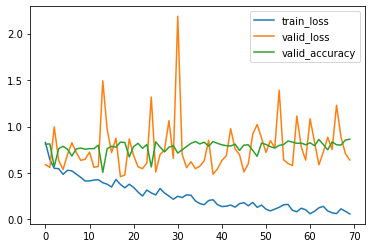

In [52]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [53]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9818242833290525
TEST
loss: 0.7468057488638257
accuracy: 0.6825396825396826
******************
epoch: 1
Train
0.7621337972622811
TEST
loss: 0.7596696289758834
accuracy: 0.7365079365079366
******************
epoch: 2
Train
0.6804697751714844
TEST
loss: 0.6797006873857407
accuracy: 0.7492063492063492
******************
epoch: 3
Train
0.657994946001824
TEST
loss: 0.5534938623034765
accuracy: 0.8
******************
epoch: 4
Train
0.5997563684100287
TEST
loss: 0.5725633774484907
accuracy: 0.7968253968253968
******************
epoch: 5
Train
0.6146561200416116
TEST
loss: 0.5792979575338818
accuracy: 0.765079365079365
******************
epoch: 6
Train
0.6178392844364887
TEST
loss: 0.6659946095375787
accuracy: 0.7904761904761904
******************
epoch: 7
Train
0.575415608095119
TEST
loss: 0.5619961959029001
accuracy: 0.8
******************
epoch: 8
Train
0.5967231383865271
TEST
loss: 0.6630801439285279
accuracy: 0.7587301587301587
**************

In [54]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8375634517766497


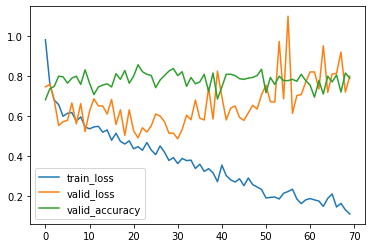

In [55]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [56]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8348102881569442
TEST
loss: 0.6744823889126853
accuracy: 0.7428571428571429
******************
epoch: 1
Train
0.6657466634670073
TEST
loss: 0.8979246875596425
accuracy: 0.819047619047619
******************
epoch: 2
Train
0.6017804679840306
TEST
loss: 0.6542810392758203
accuracy: 0.7682539682539683
******************
epoch: 3
Train
0.555666372594235
TEST
loss: 0.6827276483414665
accuracy: 0.726984126984127
******************
epoch: 4
Train
0.5475871483895208
TEST
loss: 0.6896290987256973
accuracy: 0.7174603174603175
******************
epoch: 5
Train
0.5241551463617229
TEST
loss: 0.6547762049569024
accuracy: 0.7746031746031746
******************
epoch: 6
Train
0.5573555765831821
TEST
loss: 0.5483498003747728
accuracy: 0.7714285714285715
******************
epoch: 7
Train
0.5314483156367084
TEST
loss: 0.5690304258513073
accuracy: 0.7682539682539683
******************
epoch: 8
Train
0.5534015355647983
TEST
loss: 0.6069554029949128
accuracy: 0.7

In [57]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8401015228426396


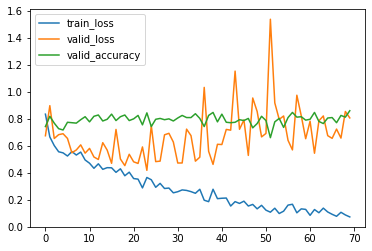

In [58]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [59]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9303214911717664
TEST
loss: 0.8226355946253217
accuracy: 0.6444444444444445
******************
epoch: 1
Train
0.7808459201817289
TEST
loss: 1.9496450866971697
accuracy: 0.2920634920634921
******************
epoch: 2
Train
0.6998995863984179
TEST
loss: 0.6570526316052392
accuracy: 0.7714285714285715
******************
epoch: 3
Train
0.6471380611749942
TEST
loss: 0.5643952471869332
accuracy: 0.7873015873015873
******************
epoch: 4
Train
0.6167721354932989
TEST
loss: 0.5321253585436988
accuracy: 0.819047619047619
******************
epoch: 5
Train
0.6327080932564921
TEST
loss: 0.6192455004131984
accuracy: 0.8031746031746032
******************
epoch: 6
Train
0.6301064747396776
TEST
loss: 0.6504449479163639
accuracy: 0.7714285714285715
******************
epoch: 7
Train
0.622192450702143
TEST
loss: 0.6723007974170503
accuracy: 0.7555555555555555
******************
epoch: 8
Train
0.6119635373093573
TEST
loss: 0.5815329656714485
accuracy: 0.

In [60]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8401015228426396


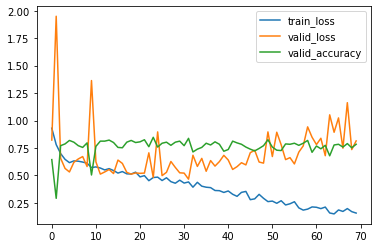

In [61]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [62]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8063861796835096
TEST
loss: 1.4090215315894474
accuracy: 0.6952380952380952
******************
epoch: 1
Train
0.6198419694203626
TEST
loss: 0.6168543904546707
accuracy: 0.7873015873015873
******************
epoch: 2
Train
0.546477905287451
TEST
loss: 0.610459608123416
accuracy: 0.765079365079365
******************
epoch: 3
Train
0.4964517122038401
TEST
loss: 0.7324539928209214
accuracy: 0.6603174603174603
******************
epoch: 4
Train
0.4841353743676632
TEST
loss: 0.655434763431549
accuracy: 0.7301587301587301
******************
epoch: 5
Train
0.44116900744089727
TEST
loss: 0.6080361650103614
accuracy: 0.7746031746031746
******************
epoch: 6
Train
0.4543800638534419
TEST
loss: 1.553438963587322
accuracy: 0.5904761904761905
******************
epoch: 7
Train
0.4791186532868195
TEST
loss: 0.7942248232780941
accuracy: 0.726984126984127
******************
epoch: 8
Train
0.3807892495791433
TEST
loss: 0.6928931282626258
accuracy: 0.806

In [63]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8375634517766497


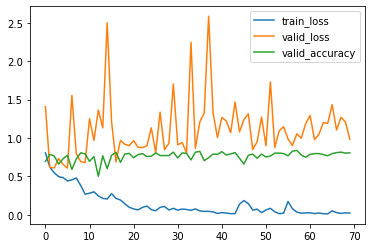

In [64]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [65]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8135550693446819
TEST
loss: 1.7436643664799039
accuracy: 0.6126984126984127
******************
epoch: 1
Train
0.6815964749069607
TEST
loss: 0.7495164657395984
accuracy: 0.6825396825396826
******************
epoch: 2
Train
0.5594637060657771
TEST
loss: 0.5876640324554746
accuracy: 0.8063492063492064
******************
epoch: 3
Train
0.530057959844424
TEST
loss: 0.5895041147867839
accuracy: 0.7619047619047619
******************
epoch: 4
Train
0.46058884199125794
TEST
loss: 0.7175789914433919
accuracy: 0.7619047619047619
******************
epoch: 5
Train
0.45804424724756865
TEST
loss: 0.6098939484074002
accuracy: 0.8031746031746032
******************
epoch: 6
Train
0.4785061997965842
TEST
loss: 0.981883322246491
accuracy: 0.7174603174603175
******************
epoch: 7
Train
0.43608595682951645
TEST
loss: 0.8521297842737228
accuracy: 0.746031746031746
******************
epoch: 8
Train
0.4441907645408079
TEST
loss: 1.026295658898732
accuracy: 0

In [66]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


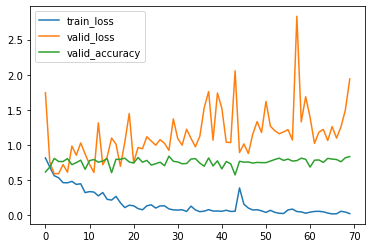

In [67]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [68]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8116338057968709
TEST
loss: 2.728721648927719
accuracy: 0.6444444444444445
******************
epoch: 1
Train
0.6582216221345049
TEST
loss: 0.6120332733033196
accuracy: 0.7682539682539683
******************
epoch: 2
Train
0.5546391627635153
TEST
loss: 0.5967850808113341
accuracy: 0.7873015873015873
******************
epoch: 3
Train
0.4974579388324565
TEST
loss: 0.5723933874614655
accuracy: 0.7904761904761904
******************
epoch: 4
Train
0.4821957639988876
TEST
loss: 0.6019106635971675
accuracy: 0.7396825396825397
******************
epoch: 5
Train
0.4775496908508661
TEST
loss: 0.7612321350309584
accuracy: 0.7746031746031746
******************
epoch: 6
Train
0.5006290860503699
TEST
loss: 0.5739122205310397
accuracy: 0.7396825396825397
******************
epoch: 7
Train
0.5029114988988311
TEST
loss: 1.7955386911119733
accuracy: 0.638095238095238
******************
epoch: 8
Train
0.4410457426683594
TEST
loss: 0.5863696115357535
accuracy: 0.

In [69]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8451776649746193


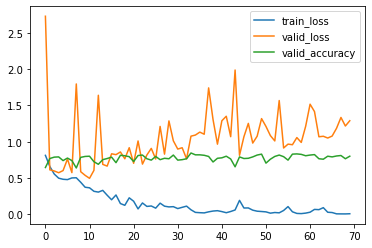

In [70]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [71]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.7737141606161952
TEST
loss: 1.8496890560029045
accuracy: 0.5492063492063493
******************
epoch: 1
Train
0.6151209434552075
TEST
loss: 0.6479766397249132
accuracy: 0.7333333333333333
******************
epoch: 2
Train
0.5269319895385655
TEST
loss: 0.9323517674491519
accuracy: 0.7619047619047619
******************
epoch: 3
Train
0.501808085192566
TEST
loss: 0.5442532463679238
accuracy: 0.765079365079365
******************
epoch: 4
Train
0.4616101144608095
TEST
loss: 0.8262270079718695
accuracy: 0.6730158730158731
******************
epoch: 5
Train
0.4396395716665282
TEST
loss: 0.6048071269005064
accuracy: 0.7682539682539683
******************
epoch: 6
Train
0.48528739504628565
TEST
loss: 0.579751135432531
accuracy: 0.7904761904761904
******************
epoch: 7
Train
0.40001271905361235
TEST
loss: 0.6621403925002567
accuracy: 0.8317460317460318
******************
epoch: 8
Train
0.39312252795251235
TEST
loss: 0.9777240955640399
accuracy: 

In [72]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


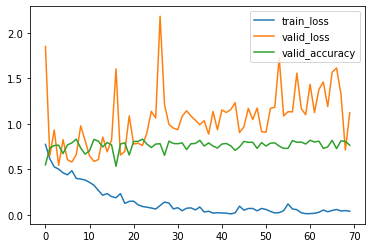

In [73]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [74]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8352874583720782
TEST
loss: 1.328704401424953
accuracy: 0.3904761904761905
******************
epoch: 1
Train
0.7222779320524836
TEST
loss: 0.6317464730096242
accuracy: 0.7396825396825397
******************
epoch: 2
Train
0.5772508750651165
TEST
loss: 0.6279221330370222
accuracy: 0.7746031746031746
******************
epoch: 3
Train
0.5492389114533652
TEST
loss: 0.5984624551402198
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.4967025195302425
TEST
loss: 0.7741432426467775
accuracy: 0.7206349206349206
******************
epoch: 5
Train
0.4938793866713905
TEST
loss: 2.684349949397738
accuracy: 0.31746031746031744
******************
epoch: 6
Train
0.5282080062000026
TEST
loss: 2.627161489214216
accuracy: 0.346031746031746
******************
epoch: 7
Train
0.5300747399011996
TEST
loss: 0.7396250246063111
accuracy: 0.6984126984126984
******************
epoch: 8
Train
0.4513300460562808
TEST
loss: 0.7443874783932216
accuracy: 0.7

In [75]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8274111675126904


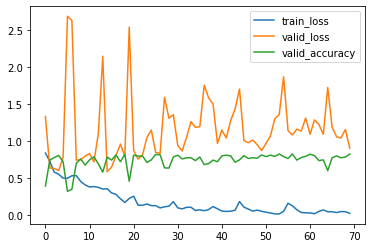

In [76]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [77]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9850518666059844
TEST
loss: 0.9479641204788571
accuracy: 0.7238095238095238
******************
epoch: 1
Train
0.7318384042327796
TEST
loss: 0.6632295837478032
accuracy: 0.765079365079365
******************
epoch: 2
Train
0.6117337582791202
TEST
loss: 1.2702485686256773
accuracy: 0.5079365079365079
******************
epoch: 3
Train
0.5764122981226
TEST
loss: 0.5433398814428421
accuracy: 0.819047619047619
******************
epoch: 4
Train
0.5252837951075378
TEST
loss: 0.49240625585828507
accuracy: 0.834920634920635
******************
epoch: 5
Train
0.4933227167847234
TEST
loss: 0.549155387708119
accuracy: 0.7936507936507936
******************
epoch: 6
Train
0.5491372324390199
TEST
loss: 0.7921736707763066
accuracy: 0.6857142857142857
******************
epoch: 7
Train
0.5212425554054327
TEST
loss: 0.6200355054840209
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.45163764042973614
TEST
loss: 0.6673408362600538
accuracy: 0.812

In [78]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8324873096446701


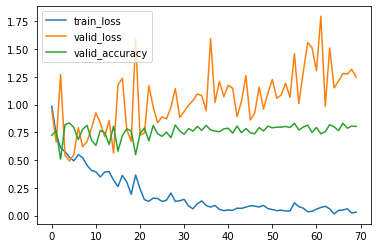

In [79]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()